In [4]:
# Victor Z, Jaron T
# UW-Madison, 2024
# linear regression and uncertainty quantification for heat capacity

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm
from sklearn.linear_model import LinearRegression

In [6]:
# define ellipse function
# adapted from ellipse.m - Copyright (C) 2001, James B. Rawlings and John W. Eaton

def ellipse(amat, level, n=100, shift=None):
    if shift is None:
        shift = np.array([0, 0])

    shift = np.asarray(shift)

    if shift.shape != (2,):
        if shift.shape == (2, 1):
            shift = shift.flatten()
        else:
            raise ValueError('shift must be a 2-element row vector')

    # Use eigh instead of eig for symmetric matrices
    dl, v = np.linalg.eigh(amat / level)
    l = np.diag(dl)

    if np.any(np.imag(dl)) or np.any(dl <= 0):
        raise ValueError('ellipse: amat must be positive definite')

    # Generate contour data
    a = 1 / np.sqrt(dl[0])
    b = 1 / np.sqrt(dl[1])

    t = np.linspace(0, 2 * np.pi, n)
    xt = a * np.cos(t)
    yt = b * np.sin(t)

    # Rotate the contours
    ra = np.arctan2(v[1, 0], v[0, 0])

    cos_ra = np.cos(ra)
    sin_ra = np.sin(ra)

    x = xt * cos_ra - yt * sin_ra + shift[0]
    y = xt * sin_ra + yt * cos_ra + shift[1]

    # Endpoints of the major and minor axes
    minor = (v @ np.diag([a, b])).T
    major = minor.copy()

    major[1, :] = -major[0, :]
    minor[0, :] = -minor[1, :]

    t = np.array([shift, shift])
    major += t
    minor += t

    # Bounding box for the ellipse using magic formula
    ainv = np.linalg.inv(amat)
    xbox = np.sqrt(level * ainv[0, 0])
    ybox = np.sqrt(level * ainv[1, 1])

    bbox = np.array([
        [xbox, ybox],
        [xbox, -ybox],
        [-xbox, -ybox],
        [-xbox, ybox],
        [xbox, ybox]
    ])

    t = np.tile(shift, (5, 1))
    bbox += t

    return x, y, major, minor, bbox

In [7]:
# Generate data
a0 = +0.6190e+1
a1 = +0.2923e-2
a2 = -0.7052e-6
theta = np.array([a0, a1, a2])

# 3 sets of experiments at T=300K, T=600K, and T=900K
n = 10
N = 3 * n
x1 = np.linspace(300, 300, n)
x2 = np.linspace(600, 600, n)
x3 = np.linspace(900, 900, n)
x = np.concatenate([x1, x2, x3])

# Generate true outputs
np.random.seed(0)
y1 = a0 + a1 * x1 + a2 * x1**2
y2 = a0 + a1 * x2 + a2 * x2**2
y3 = a0 + a1 * x3 + a2 * x3**2
ytrue = np.concatenate([y1, y2, y3])

# Add random noise to true outputs
sigma = 0.1
y = ytrue + np.random.normal(0, sigma, N)

# Construct input and output data matrix for MLE
xsq = x**2
X = np.column_stack([np.ones(N), x, xsq])
Y = y

# Obtain best fit parameters
reg = LinearRegression(fit_intercept=False).fit(X, Y)
thetaest = reg.coef_

Yhat = X @ thetaest
e = Y - Yhat
mu, sigma_est = norm.fit(e)
sig2 = sigma_est**2
C = np.linalg.inv(X.T @ X) * sig2


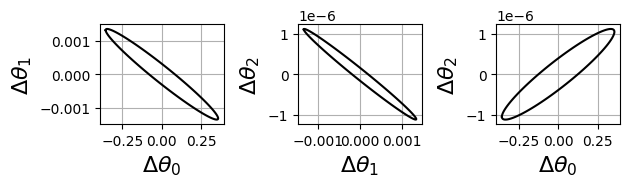

In [10]:
# Visualization

# Visualize 1-2 pair
Sigma = C[:2, :2]
mu = np.array([0, 0])
alpha = 0.95
n = 2
A = np.linalg.inv(Sigma)
b = chi2.ppf(alpha, n)
xe, ye, major, minor, bbox = ellipse(A, b, 100, mu)

plt.figure(1)
plt.subplot(3, 3, 1)
plt.plot(xe, ye, 'black')
plt.plot(0, 0) #, 'black+')
plt.grid(True)
plt.xlabel(r'$\Delta \theta_0$', fontsize=16)
plt.ylabel(r'$\Delta \theta_1$', fontsize=16)

# Visualize 2-3 pair
Sigma = C[1:3, 1:3]
mu = np.array([0, 0])
A = np.linalg.inv(Sigma)
xe, ye, major, minor, bbox = ellipse(A, b, 100, mu)

plt.subplot(3, 3, 2)
plt.plot(xe, ye, 'black')
plt.plot(0, 0) # , 'black+')
plt.grid(True)
plt.xlabel(r'$\Delta \theta_1$', fontsize=16)
plt.ylabel(r'$\Delta \theta_2$', fontsize=16)

# Visualize 1-3 pair
Sigma = C[[0, 2]][:, [0, 2]]
mu = np.array([0, 0])
A = np.linalg.inv(Sigma)
xe, ye, major, minor, bbox = ellipse(A, b, 100, mu)

plt.subplot(3, 3, 3)
plt.plot(xe, ye, 'black')
plt.grid(True)
plt.plot(0, 0) #, 'black+')
plt.xlabel(r'$\Delta \theta_0$', fontsize=16)
plt.ylabel(r'$\Delta \theta_2$', fontsize=16)
plt.tight_layout()


In [11]:
# Parameters confidence 95% intervals (bounding box)
chi = chi2.ppf(0.95, 3)
conf = np.sqrt(np.diag(C) * chi)
Confth = np.column_stack([thetaest - conf, thetaest + conf, theta])

# Parameters confidence 95% intervals (marginals)
chi = chi2.ppf(0.95, 1)
conf = np.sqrt(np.diag(C) * chi)
Confth_marginal = np.column_stack([thetaest - conf, thetaest + conf, theta])

# Outputs confidence 95% intervals
chi = chi2.ppf(0.95, N)
Cy = X @ C @ X.T
conf = np.sqrt(np.diag(Cy) * chi)
Confy = np.column_stack([Yhat - conf, Yhat + conf, Yhat, Y])



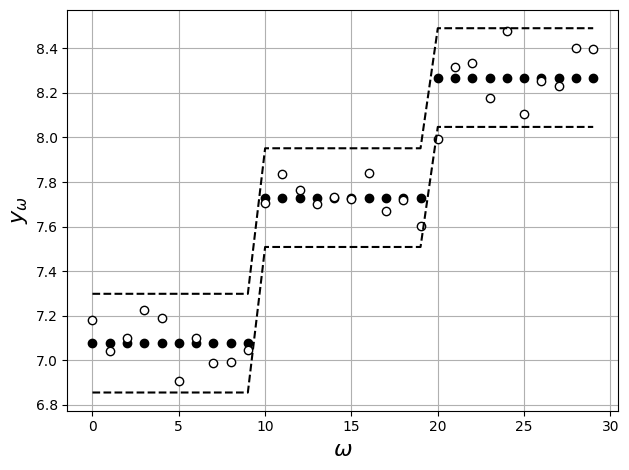

In [12]:
plt.figure(3)
plt.plot(Yhat, 'ko', markerfacecolor='black')
plt.plot(Y, 'ko', markerfacecolor='white')
plt.plot(Yhat - conf, 'k--')
plt.plot(Yhat + conf, 'k--')
plt.grid(True)
plt.xlabel(r'$\omega$', fontsize=16)
plt.ylabel(r'$y_\omega$', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
# Try Python built-in functions
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, Y)
thetaest = reg.coef_
Yhat = reg.predict(X)

# Get parameter confidence intervals
import statsmodels.api as sm
X_const = sm.add_constant(np.column_stack([x, xsq]))
model = sm.OLS(Y, X_const).fit()
CI = model.conf_int()
print(CI)

[[ 5.99478266e+00  6.62562366e+00]
 [ 1.55330619e-03  3.94114441e-03]
 [-1.61957716e-06  3.49878602e-07]]
